<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/finished_universal_trading_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import yfinance as yf
import time, os, tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
from math import ceil

In [ ]:
#TensorFlow GPU Memory Configuration
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow GPU memory growth enabled")
    except RuntimeError as e:
        print(f" TensorFlow GPU memory issue: {e}")

os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'

In [ ]:
#CONFIG
CONFIG = {
    'symbols': [  #Use this list directly
        'AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'JPM', 'JNJ',
        'XOM', 'V', 'PG', 'UNH', 'MA', 'HD', 'LLY', 'MRK', 'PEP', 'KO',
        'BAC', 'ABBV', 'AVGO', 'PFE', 'COST', 'CSCO', 'TMO', 'ABT', 'ACN', 'WMT',
        'MCD', 'ADBE', 'DHR', 'CRM', 'NKE', 'INTC', 'QCOM', 'NEE', 'AMD', 'TXN',
        'AMGN', 'UPS', 'LIN', 'PM', 'UNP', 'BMY', 'LOW', 'RTX', 'CVX', 'IBM',
        'GE', 'SBUX', 'ORCL'
    ],
    'period': '720d',
    'interval': '1h',
    'lookahead': 10,
    'threshold_factor': 2,
    'features': ['SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band', 'Stoch', 'volatility'],
    'target': 'Target',
    'sharpe_threshold': 1.5,
    'return_threshold': 1.25
}



In [ ]:
#Data Download Function
def download_stock_data(ticker, period="720d", interval="1h", max_retries=5):
    for attempt in range(1, max_retries + 1):
        try:
            print(f"Attempt {attempt}: Downloading {ticker} stock data...")
            df_live = yf.download(ticker, period=period, interval=interval)
            if not df_live.empty:
                print("Successfully downloaded stock data for", ticker)
                df_live.reset_index(inplace=True)
                df_live['Symbol'] = ticker
                return df_live
            raise ValueError("Downloaded data is empty. Retrying...")
        except Exception as e:
            print(f"Error: {e}. Retrying in {attempt * 5} seconds...")
            time.sleep(attempt * 5)
    print("Failed to download stock data after multiple attempts for", ticker)
    return None


In [ ]:
#Enhanced Feature Engineering Function
def compute_technical_indicators(df):
    df = df.copy()

    #Fix MultiIndex columns and drop duplicates
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df.loc[:, ~df.columns.duplicated()]

    #Moving Average and Bollinger Bands
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['STD_20'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['SMA_20'] + 2 * df['STD_20']
    df['Lower_Band'] = df['SMA_20'] - 2 * df['STD_20']

    #Stochastic Oscillator
    df['Lowest_Low'] = df['Low'].rolling(window=14).min()
    df['Highest_High'] = df['High'].rolling(window=14).max()
    denominator = (df['Highest_High'] - df['Lowest_Low']).replace(0, np.nan)
    df['Stoch'] = ((df['Close'] - df['Lowest_Low']) / denominator) * 100

    #Rate of Change (Momentum)
    df['ROC'] = df['Close'].pct_change(periods=10)

    #On-Balance Volume
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()

    #Commodity Channel Index (CCI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    df['CCI'] = (typical_price - typical_price.rolling(window=20).mean()) / (
        0.015 * typical_price.rolling(window=20).std()
    )

    # Price Rate of Change (PROC)
    df['PROC'] = ((df['Close'] - df['Close'].shift(12)) / df['Close'].shift(12)) * 100

    #Rolling and Expanding Means
    df['Rolling_Mean_50'] = df['Close'].rolling(window=50).mean()
    df['Expanding_Mean'] = df['Close'].expanding(min_periods=1).mean()

    #Volatility
    df['volatility'] = df['Close'].pct_change().rolling(20).std()

    #Drop rows with NaN from rolling calculations
    df.dropna(inplace=True)

    return df


In [ ]:
#Label Generator
def generate_trade_labels(df, lookahead=10, threshold_factor=2):
    df['Future_Close'] = df['Close'].shift(-lookahead)
    df['Price_Change'] = (df['Future_Close'] - df['Close']) / df['Close']
    df['Target'] = np.where(df['Price_Change'] > 0.03, 1, 0)

    buy_threshold = df['volatility'] * threshold_factor
    sell_threshold = -df['volatility'] * threshold_factor
    df['Dynamic_Label'] = np.where(df['Price_Change'] > buy_threshold, 1,
                            np.where(df['Price_Change'] < sell_threshold, -1, 0))

    df.dropna(inplace=True)
    return df

In [ ]:
# ✅ Simple Backtest
def simple_backtest(df, target_col='Target'):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df[target_col].shift(1) * df['Return']
    df['Equity_Curve'] = (1 + df['Strategy_Return']).cumprod()
    return df


In [ ]:
#Performance Metrics Evaluation
def evaluate_performance_metrics(df, risk_free_rate=0.0):
    metrics = {}

    # Ensure datetime is properly formatted and used as index
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Daily returns
    daily_returns = df['Equity_Curve'].pct_change().dropna()

    # Sharpe Ratio
    excess_returns = daily_returns - risk_free_rate / 252
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    metrics['Sharpe Ratio'] = sharpe_ratio

    # Win/Loss Ratio
    trade_returns = df['Strategy_Return'][df['Strategy_Return'] != 0]
    wins = trade_returns[trade_returns > 0].count()
    losses = trade_returns[trade_returns < 0].count()
    metrics['Win/Loss Ratio'] = wins / losses if losses > 0 else np.inf

    # Max Drawdown
    roll_max = df['Equity_Curve'].cummax()
    drawdown = (df['Equity_Curve'] - roll_max) / roll_max
    metrics['Max Drawdown'] = drawdown.min()


    # CAGR
    start_value = df['Equity_Curve'].iloc[0]
    end_value = df['Equity_Curve'].iloc[-1]
    num_years = (df.index[-1] - df.index[0]).days / 365.25
    cagr = (end_value / start_value) ** (1 / num_years) - 1 if num_years > 0 else np.nan
    metrics['CAGR'] = cagr


    # Reset index before returning
    df.reset_index(inplace=True)

    return metrics


In [ ]:
def run_universal_framework(config):
    all_results = {}
    all_metrics = {}
    filtered_tickers = []

    for symbol in config['symbols']:
        print(f"Processing {symbol}")
        df = download_stock_data(symbol, config['period'], config['interval'])

        if df is None:
            print(f"Skipping {symbol} due to download error.")
            continue

        df = compute_technical_indicators(df)
        df = generate_trade_labels(df, config['lookahead'], config['threshold_factor'])

        df = simple_backtest(df, config['target'])
        metrics = evaluate_performance_metrics(df)

        final_return = df['Equity_Curve'].iloc[-1]
        sharpe = metrics.get('Sharpe Ratio', 0)

        print(f"Performance Metrics for {symbol}:")
        for k, v in metrics.items():
            print(f"   {k}: {v:.4f}")

        #Filter: Only export if criteria met
        if sharpe > config['sharpe_threshold'] or final_return > config['return_threshold']:
            print(f"{symbol} meets filter criteria. Saving...")
            all_results[symbol] = df
            all_metrics[symbol] = metrics
            filtered_tickers.append(symbol)

            # Save CSVs
            df.to_csv(f"/content/{symbol}_universal_features.csv", index=False)
            metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
            metrics_df.to_csv(f"/content/{symbol}_metrics_summary.csv")

            # Plot
            plt.figure(figsize=(10, 4))
            plt.plot(df['Datetime'], df['Equity_Curve'], label='Equity Curve')
            plt.title(f"{symbol} Strategy Performance")
            plt.xlabel("Date")
            plt.ylabel("Equity")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print(f" {symbol} did NOT meet Sharpe/Return threshold. Skipping export.")

    print(f"Exported {len(filtered_tickers)} tickers meeting criteria.")
    return all_results, all_metrics, filtered_tickers


🚀 Running chunk 1 with symbols: ['AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'JPM', 'JNJ']
Processing AAPL
Attempt 1: Downloading AAPL stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for AAPL
Performance Metrics for AAPL:
   Sharpe Ratio: 1.4524
   Win/Loss Ratio: 2.3797
   Max Drawdown: -0.0329
   CAGR: nan
AAPL meets filter criteria. Saving...


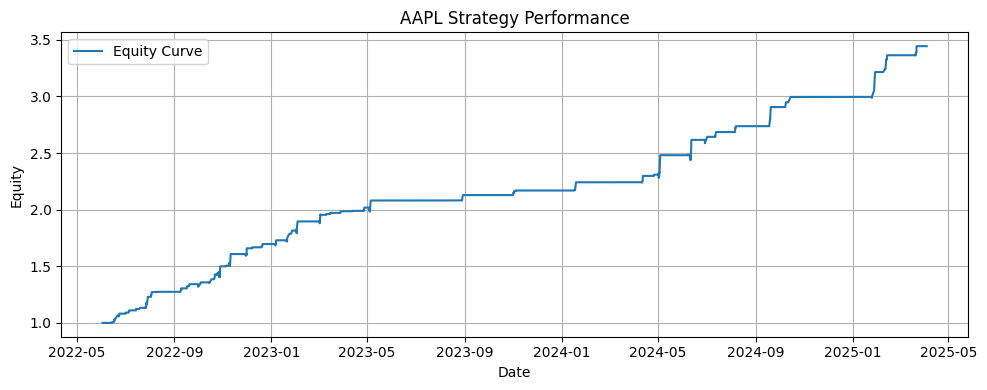

Processing TSLA
Attempt 1: Downloading TSLA stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for TSLA
Performance Metrics for TSLA:
   Sharpe Ratio: 2.6595
   Win/Loss Ratio: 1.9780
   Max Drawdown: -0.0743
   CAGR: nan
TSLA meets filter criteria. Saving...


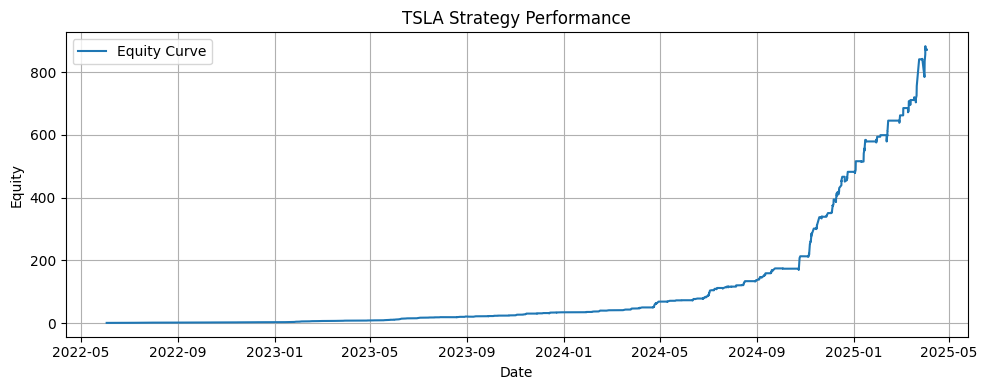

Processing MSFT
Attempt 1: Downloading MSFT stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for MSFT
Performance Metrics for MSFT:
   Sharpe Ratio: 1.4414
   Win/Loss Ratio: 1.8617
   Max Drawdown: -0.0223
   CAGR: nan
MSFT meets filter criteria. Saving...


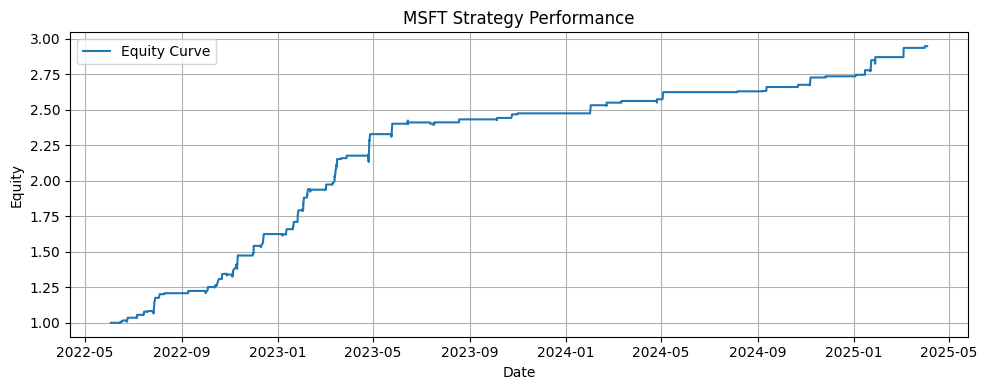

Processing GOOGL
Attempt 1: Downloading GOOGL stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for GOOGL
Performance Metrics for GOOGL:
   Sharpe Ratio: 1.6961
   Win/Loss Ratio: 2.1000
   Max Drawdown: -0.0310
   CAGR: nan
GOOGL meets filter criteria. Saving...


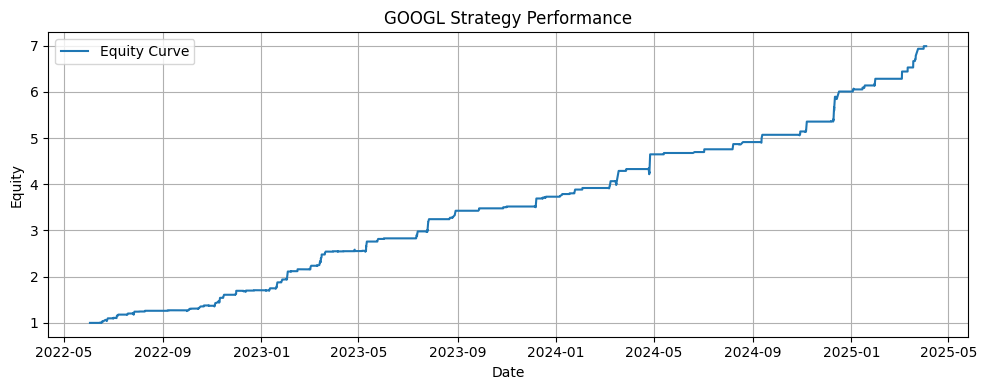

Processing AMZN
Attempt 1: Downloading AMZN stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for AMZN
Performance Metrics for AMZN:
   Sharpe Ratio: 1.7350
   Win/Loss Ratio: 2.1503
   Max Drawdown: -0.0465
   CAGR: nan
AMZN meets filter criteria. Saving...


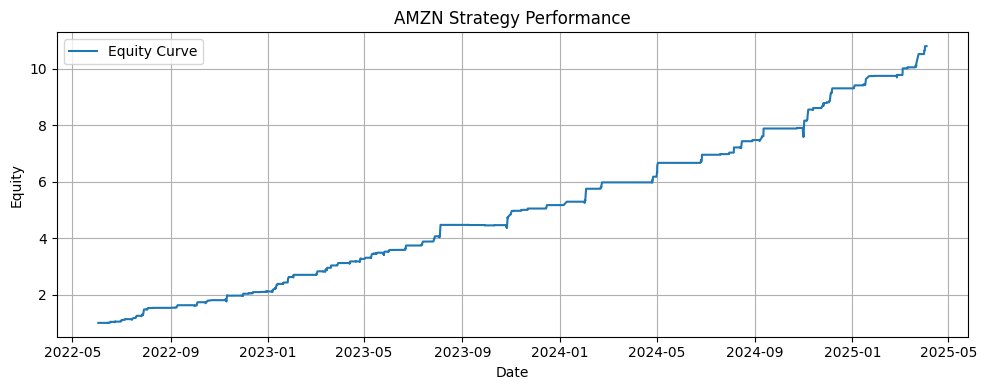

Processing NVDA
Attempt 1: Downloading NVDA stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for NVDA
Performance Metrics for NVDA:
   Sharpe Ratio: 2.5677
   Win/Loss Ratio: 1.9562
   Max Drawdown: -0.0740
   CAGR: nan
NVDA meets filter criteria. Saving...


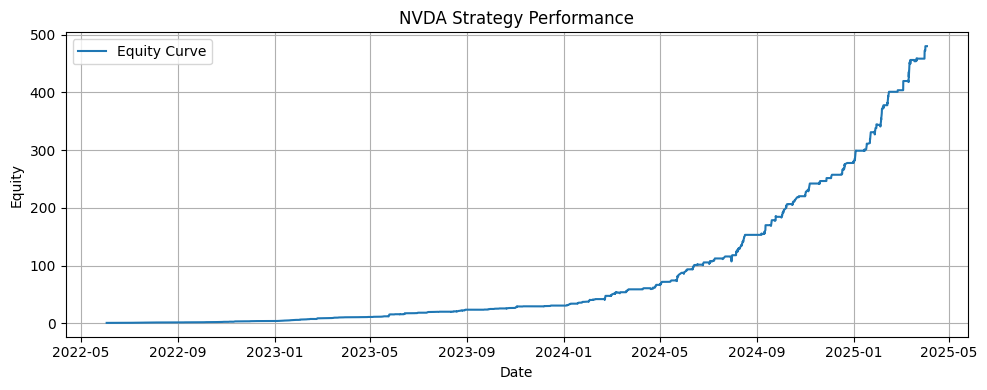

Processing META
Attempt 1: Downloading META stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for META
Performance Metrics for META:
   Sharpe Ratio: 1.6410
   Win/Loss Ratio: 1.8884
   Max Drawdown: -0.0367
   CAGR: nan
META meets filter criteria. Saving...


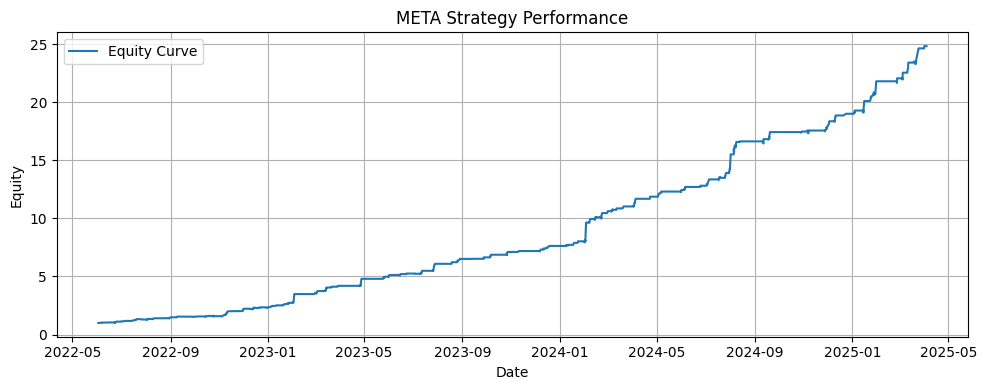

Processing BRK-B
Attempt 1: Downloading BRK-B stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for BRK-B
Performance Metrics for BRK-B:
   Sharpe Ratio: 0.8816
   Win/Loss Ratio: 1.7097
   Max Drawdown: -0.0145
   CAGR: nan
BRK-B meets filter criteria. Saving...


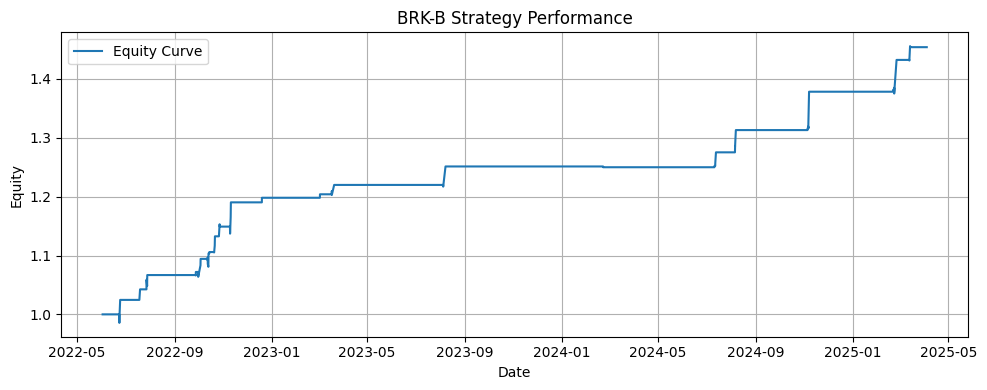

Processing JPM
Attempt 1: Downloading JPM stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for JPM
Performance Metrics for JPM:
   Sharpe Ratio: 1.2102
   Win/Loss Ratio: 2.7115
   Max Drawdown: -0.0132
   CAGR: nan
JPM meets filter criteria. Saving...


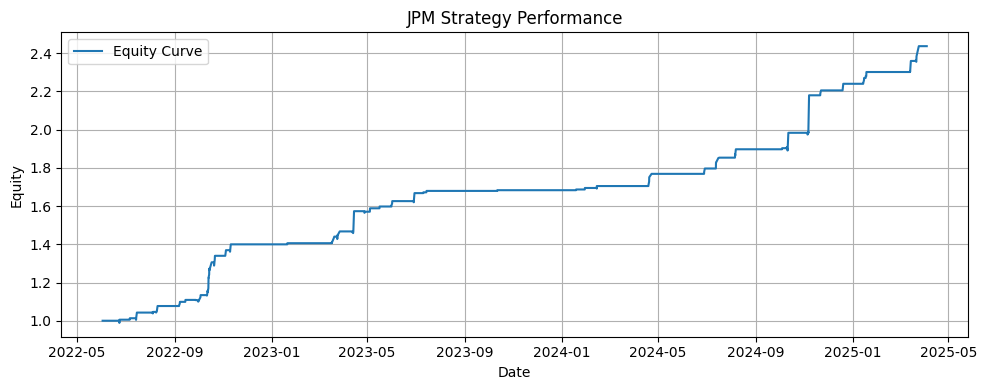

Processing JNJ
Attempt 1: Downloading JNJ stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for JNJ
Performance Metrics for JNJ:
   Sharpe Ratio: 0.7018
   Win/Loss Ratio: 1.2812
   Max Drawdown: -0.0076
   CAGR: nan
JNJ meets filter criteria. Saving...


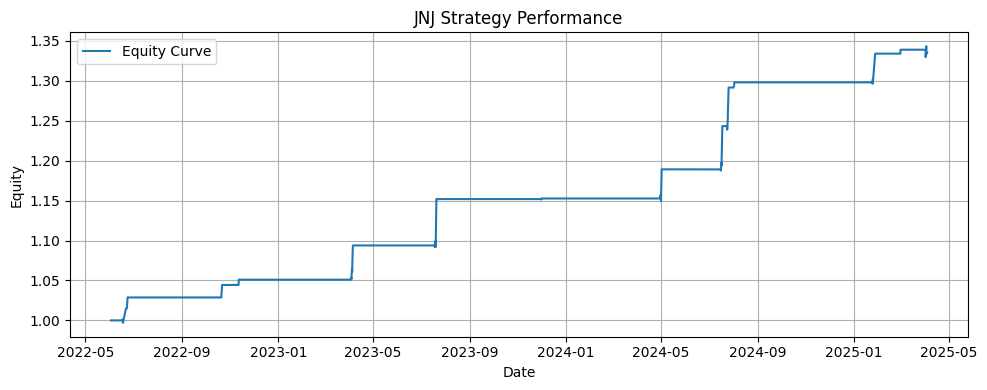

Exported 10 tickers meeting criteria.

🚀 Running chunk 2 with symbols: ['XOM', 'V', 'PG', 'UNH', 'MA', 'HD', 'LLY', 'MRK', 'PEP', 'KO']
Processing XOM
Attempt 1: Downloading XOM stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for XOM
Performance Metrics for XOM:
   Sharpe Ratio: 1.6500
   Win/Loss Ratio: 2.2706
   Max Drawdown: -0.0255
   CAGR: nan
XOM meets filter criteria. Saving...


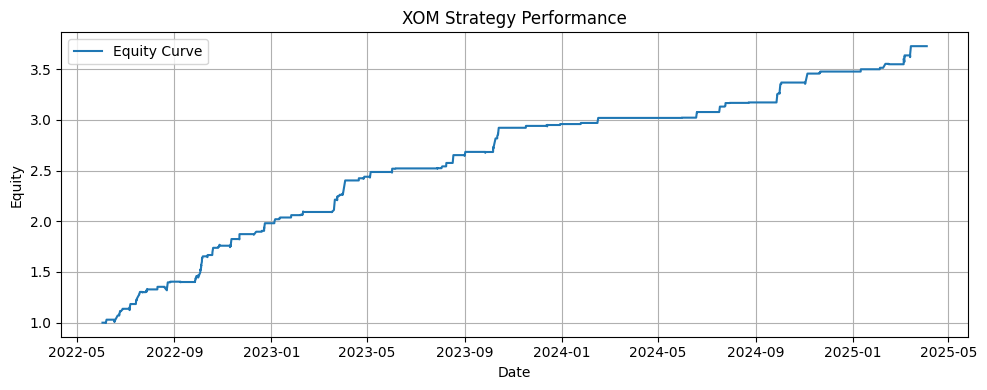

Processing V
Attempt 1: Downloading V stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for V
Performance Metrics for V:
   Sharpe Ratio: 1.0764
   Win/Loss Ratio: 1.8333
   Max Drawdown: -0.0198
   CAGR: nan
V meets filter criteria. Saving...


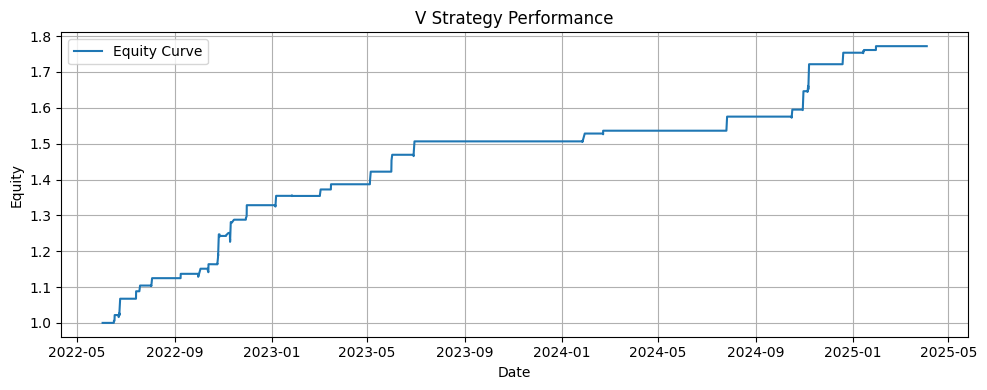

Processing PG
Attempt 1: Downloading PG stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for PG
Performance Metrics for PG:
   Sharpe Ratio: 0.7572
   Win/Loss Ratio: 2.2632
   Max Drawdown: -0.0073
   CAGR: nan
PG meets filter criteria. Saving...


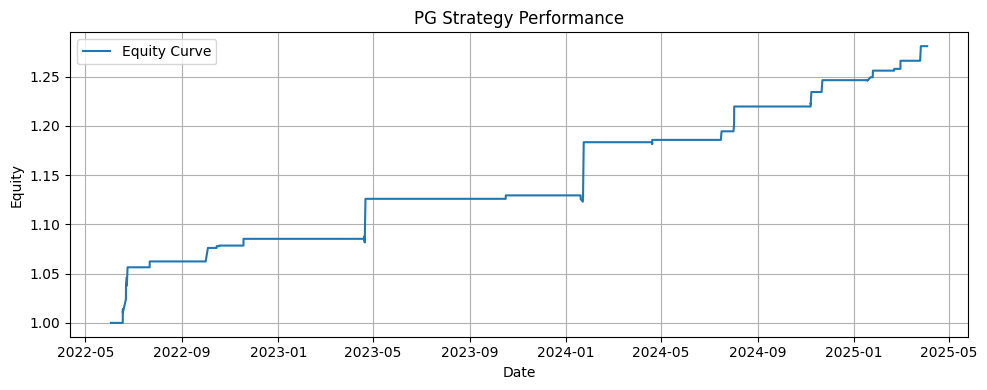

Processing UNH
Attempt 1: Downloading UNH stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for UNH
Performance Metrics for UNH:
   Sharpe Ratio: 1.1967
   Win/Loss Ratio: 1.9600
   Max Drawdown: -0.0242
   CAGR: nan
UNH meets filter criteria. Saving...


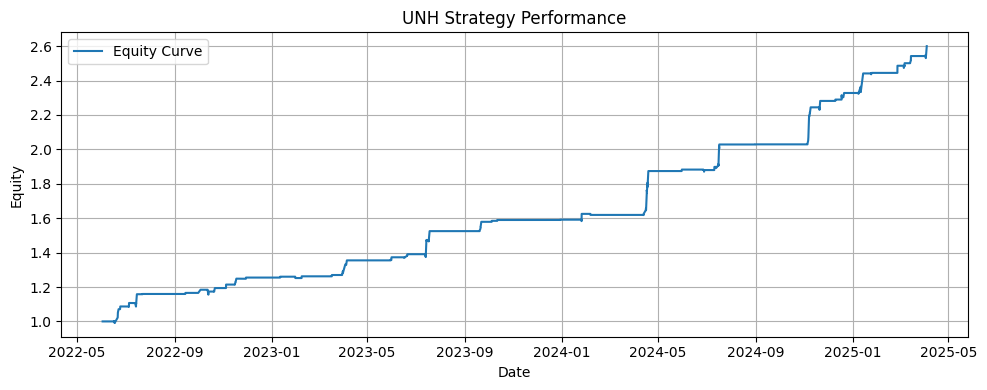

Processing MA
Attempt 1: Downloading MA stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for MA
Performance Metrics for MA:
   Sharpe Ratio: 1.1517
   Win/Loss Ratio: 1.7200
   Max Drawdown: -0.0121
   CAGR: nan
MA meets filter criteria. Saving...


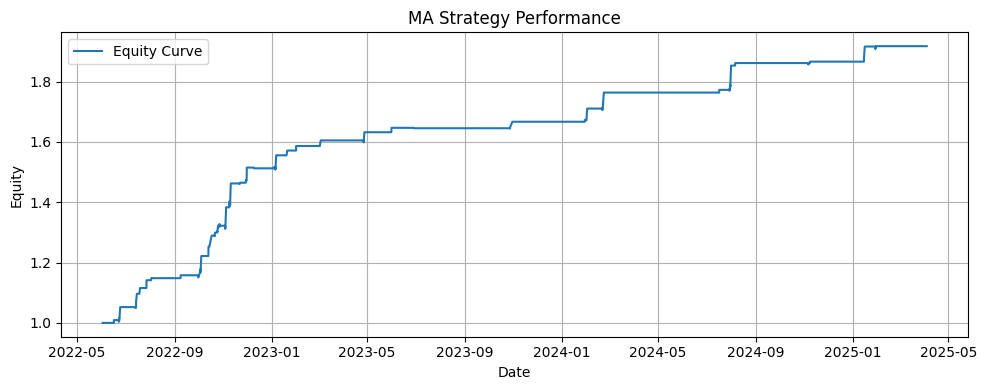

Processing HD
Attempt 1: Downloading HD stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for HD
Performance Metrics for HD:
   Sharpe Ratio: 1.2669
   Win/Loss Ratio: 2.0556
   Max Drawdown: -0.0190
   CAGR: nan
HD meets filter criteria. Saving...


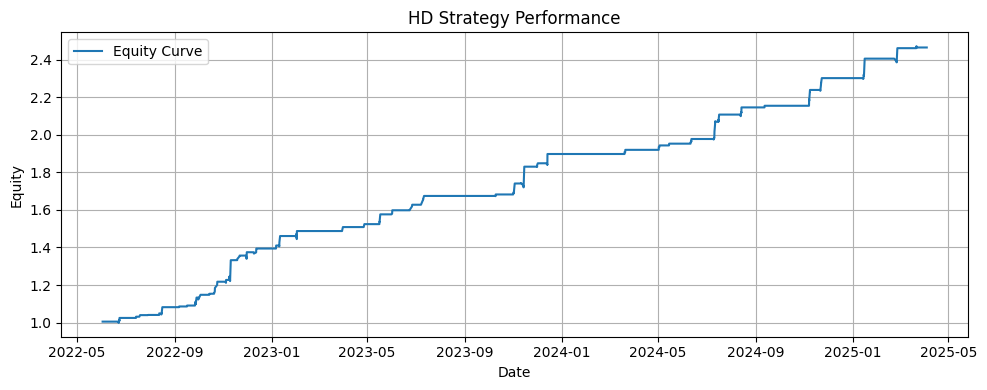

Processing LLY
Attempt 1: Downloading LLY stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for LLY
Performance Metrics for LLY:
   Sharpe Ratio: 1.5876
   Win/Loss Ratio: 2.2480
   Max Drawdown: -0.0442
   CAGR: nan
LLY meets filter criteria. Saving...


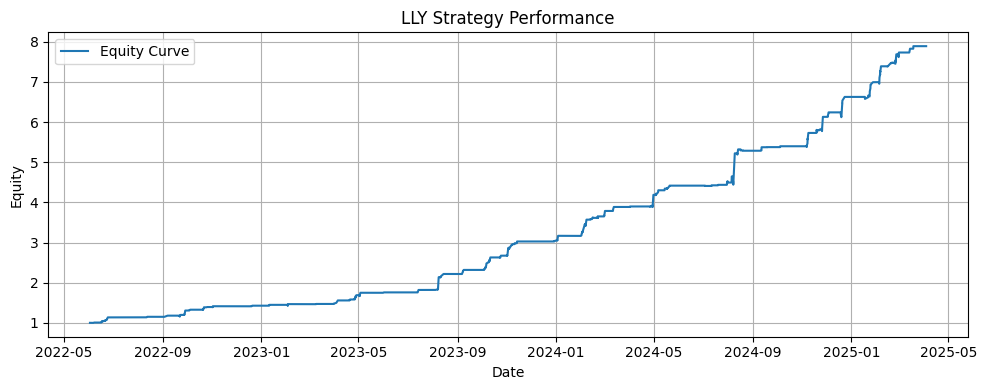

Processing MRK
Attempt 1: Downloading MRK stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for MRK
Performance Metrics for MRK:
   Sharpe Ratio: 1.1896
   Win/Loss Ratio: 2.2826
   Max Drawdown: -0.0194
   CAGR: nan
MRK meets filter criteria. Saving...


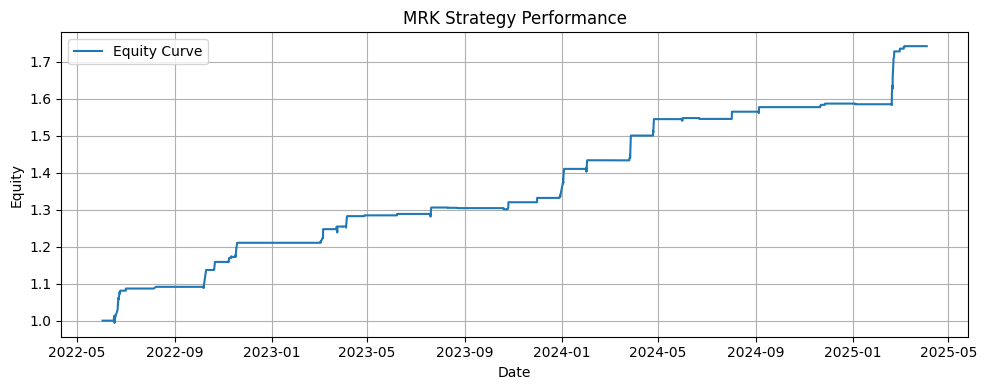

Processing PEP
Attempt 1: Downloading PEP stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for PEP
Performance Metrics for PEP:
   Sharpe Ratio: 0.8872
   Win/Loss Ratio: 2.5217
   Max Drawdown: -0.0078
   CAGR: nan
PEP meets filter criteria. Saving...


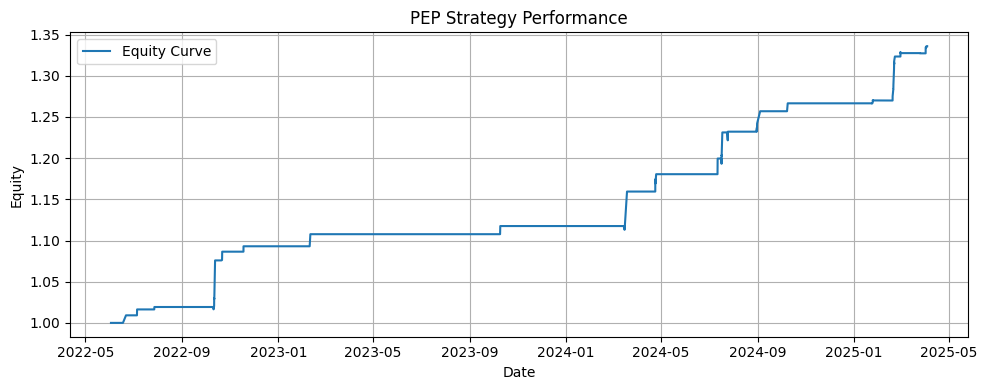

Processing KO
Attempt 1: Downloading KO stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for KO
Performance Metrics for KO:
   Sharpe Ratio: 0.7454
   Win/Loss Ratio: 2.5833
   Max Drawdown: -0.0030
   CAGR: nan
 KO did NOT meet Sharpe/Return threshold. Skipping export.
Exported 9 tickers meeting criteria.

🚀 Running chunk 3 with symbols: ['BAC', 'ABBV', 'AVGO', 'PFE', 'COST', 'CSCO', 'TMO', 'ABT', 'ACN', 'WMT']
Processing BAC
Attempt 1: Downloading BAC stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for BAC
Performance Metrics for BAC:
   Sharpe Ratio: 1.5532
   Win/Loss Ratio: 2.1386
   Max Drawdown: -0.0294
   CAGR: nan
BAC meets filter criteria. Saving...


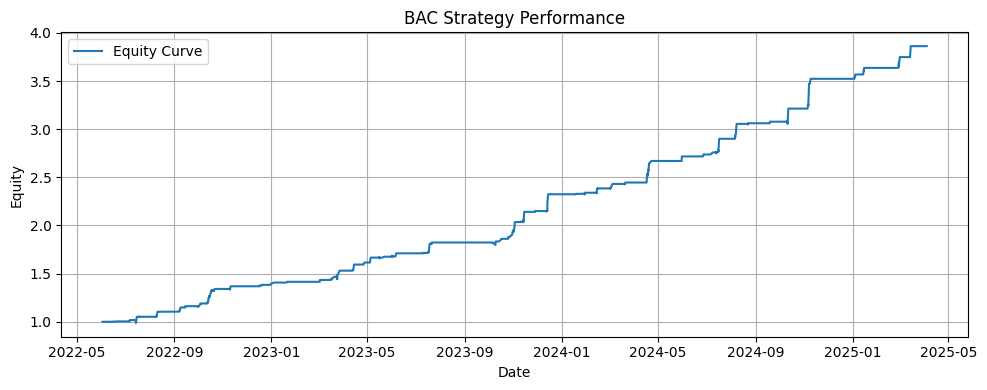

Processing ABBV
Attempt 1: Downloading ABBV stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ABBV
Performance Metrics for ABBV:
   Sharpe Ratio: 1.0783
   Win/Loss Ratio: 2.2727
   Max Drawdown: -0.0208
   CAGR: nan
ABBV meets filter criteria. Saving...


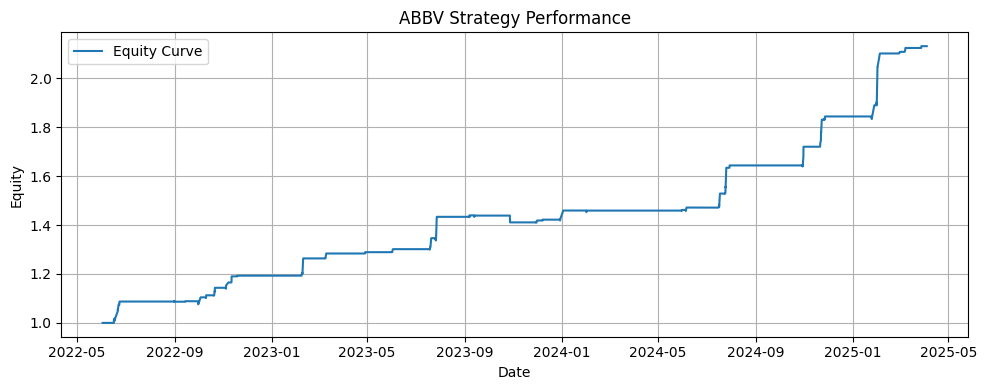

Processing AVGO
Attempt 1: Downloading AVGO stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for AVGO
Performance Metrics for AVGO:
   Sharpe Ratio: 2.0814
   Win/Loss Ratio: 2.0130
   Max Drawdown: -0.0500
   CAGR: nan
AVGO meets filter criteria. Saving...


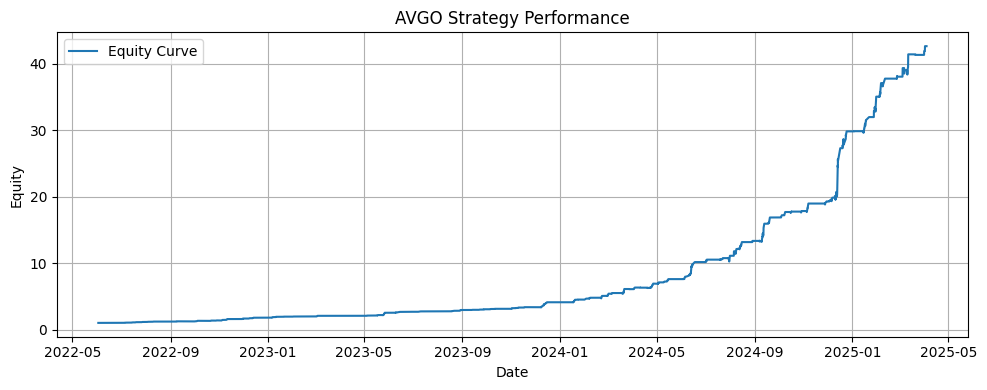

Processing PFE
Attempt 1: Downloading PFE stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for PFE
Performance Metrics for PFE:
   Sharpe Ratio: 1.3774
   Win/Loss Ratio: 2.2174
   Max Drawdown: -0.0238
   CAGR: nan
PFE meets filter criteria. Saving...


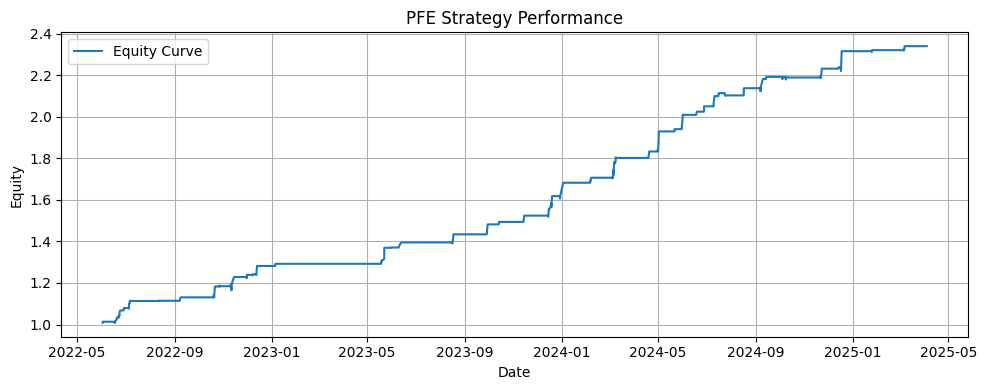

Processing COST
Attempt 1: Downloading COST stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for COST
Performance Metrics for COST:
   Sharpe Ratio: 1.1223
   Win/Loss Ratio: 1.9608
   Max Drawdown: -0.0142
   CAGR: nan
COST meets filter criteria. Saving...


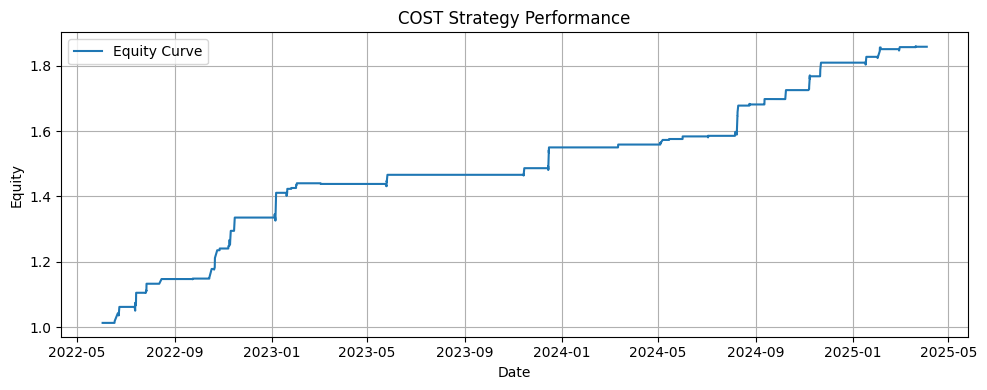

Processing CSCO
Attempt 1: Downloading CSCO stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for CSCO
Performance Metrics for CSCO:
   Sharpe Ratio: 0.9160
   Win/Loss Ratio: 2.0000
   Max Drawdown: -0.0146
   CAGR: nan
CSCO meets filter criteria. Saving...


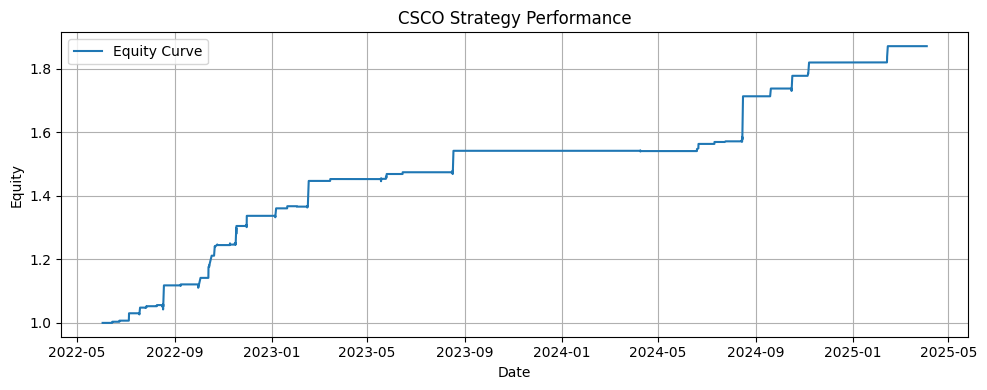

Processing TMO
Attempt 1: Downloading TMO stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for TMO
Performance Metrics for TMO:
   Sharpe Ratio: 1.4891
   Win/Loss Ratio: 1.9529
   Max Drawdown: -0.0273
   CAGR: nan
TMO meets filter criteria. Saving...


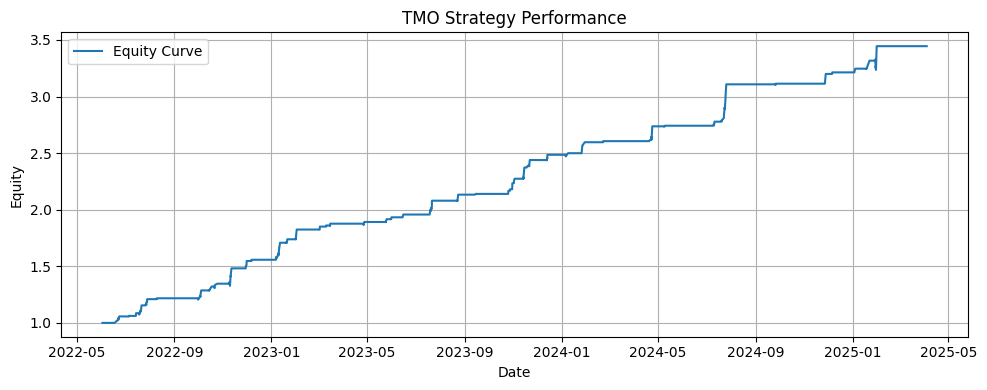

Processing ABT
Attempt 1: Downloading ABT stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ABT
Performance Metrics for ABT:
   Sharpe Ratio: 1.1283
   Win/Loss Ratio: 1.9444
   Max Drawdown: -0.0129
   CAGR: nan
ABT meets filter criteria. Saving...


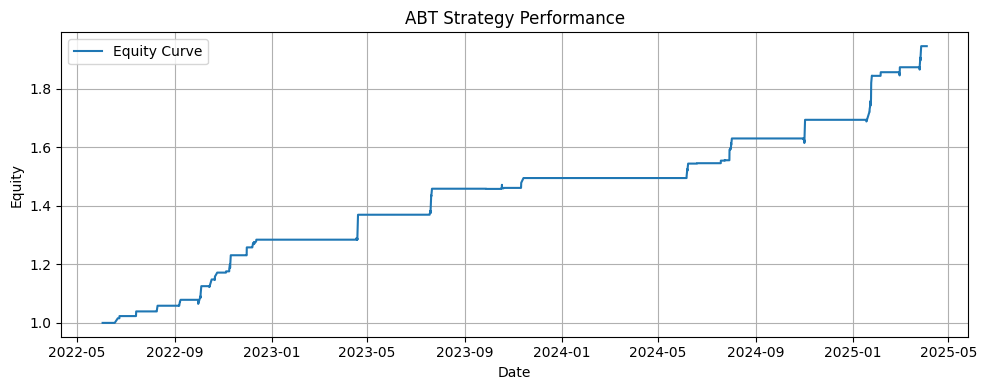

Processing ACN
Attempt 1: Downloading ACN stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ACN
Performance Metrics for ACN:
   Sharpe Ratio: 1.3172
   Win/Loss Ratio: 1.9259
   Max Drawdown: -0.0294
   CAGR: nan
ACN meets filter criteria. Saving...


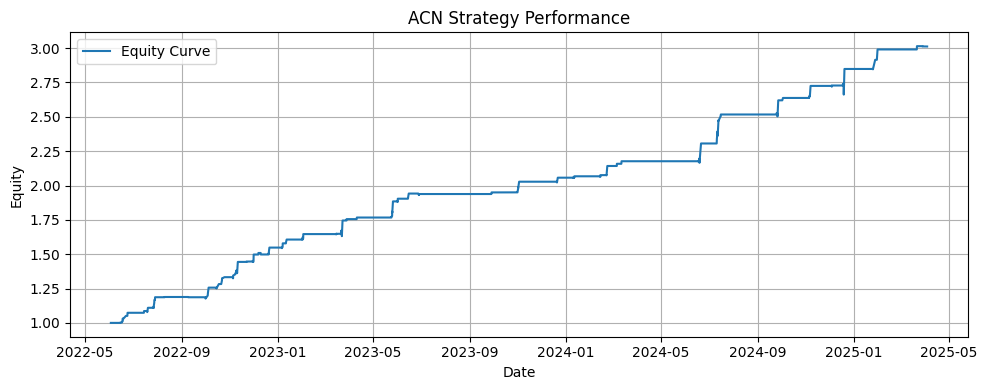

Processing WMT
Attempt 1: Downloading WMT stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for WMT
Performance Metrics for WMT:
   Sharpe Ratio: 0.7572
   Win/Loss Ratio: 1.6190
   Max Drawdown: -0.0320
   CAGR: nan
WMT meets filter criteria. Saving...


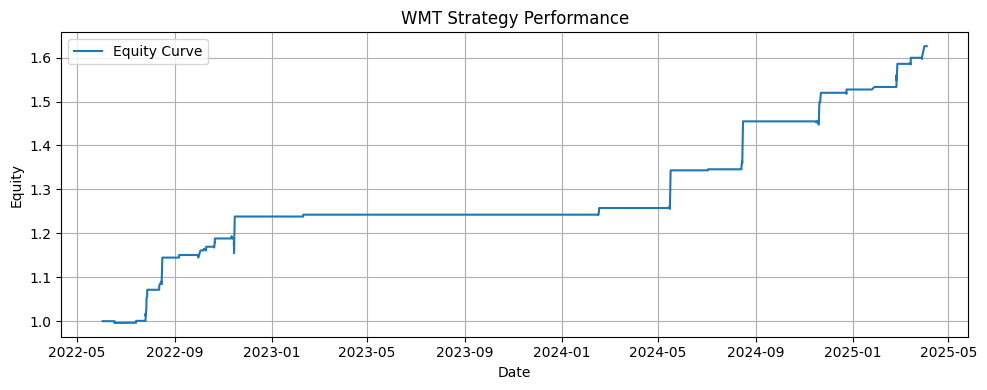

Exported 10 tickers meeting criteria.

🚀 Running chunk 4 with symbols: ['MCD', 'ADBE', 'DHR', 'CRM', 'NKE', 'INTC', 'QCOM', 'NEE', 'AMD', 'TXN']
Processing MCD
Attempt 1: Downloading MCD stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for MCD
Performance Metrics for MCD:
   Sharpe Ratio: 0.7521
   Win/Loss Ratio: 1.6552
   Max Drawdown: -0.0073
   CAGR: nan
MCD meets filter criteria. Saving...


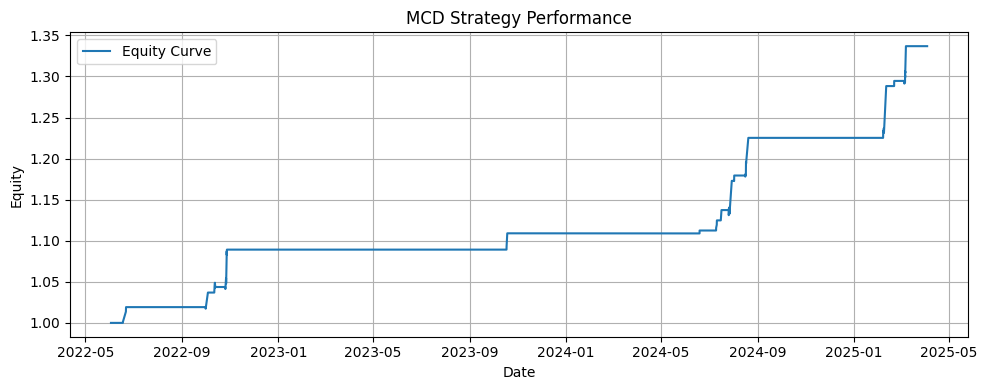

Processing ADBE
Attempt 1: Downloading ADBE stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ADBE
Performance Metrics for ADBE:
   Sharpe Ratio: 1.8193
   Win/Loss Ratio: 2.1862
   Max Drawdown: -0.0237
   CAGR: nan
ADBE meets filter criteria. Saving...


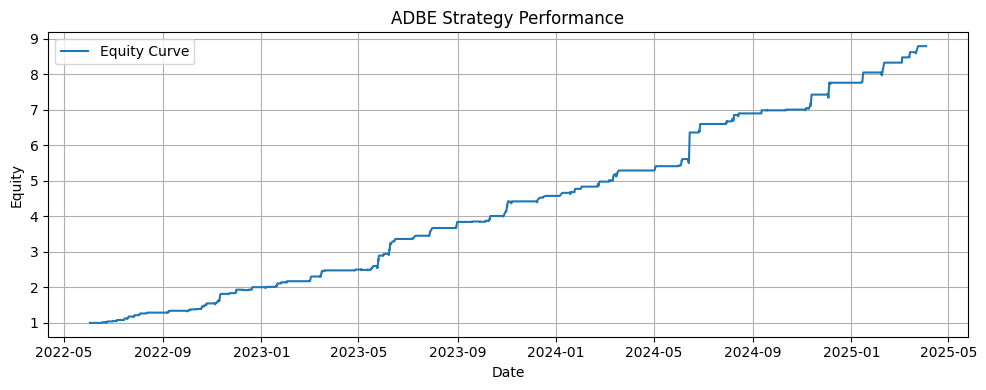

Processing DHR
Attempt 1: Downloading DHR stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for DHR
Performance Metrics for DHR:
   Sharpe Ratio: 1.4604
   Win/Loss Ratio: 2.0941
   Max Drawdown: -0.0272
   CAGR: nan
DHR meets filter criteria. Saving...


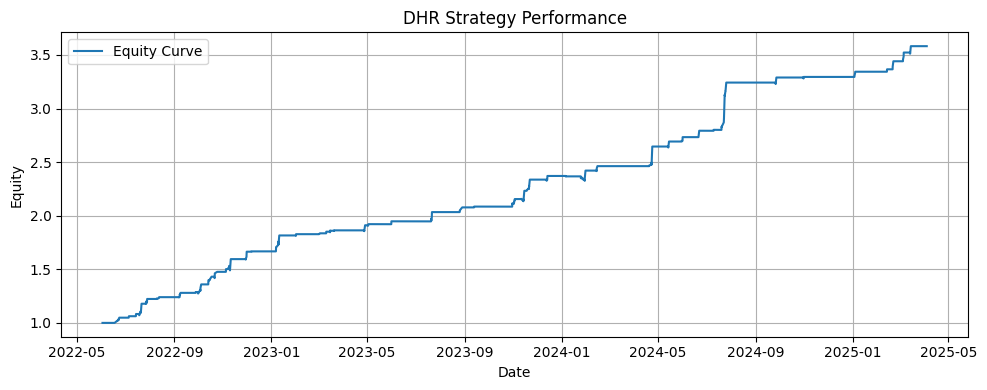

Processing CRM
Attempt 1: Downloading CRM stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for CRM
Performance Metrics for CRM:
   Sharpe Ratio: 1.8192
   Win/Loss Ratio: 1.9464
   Max Drawdown: -0.0404
   CAGR: nan
CRM meets filter criteria. Saving...


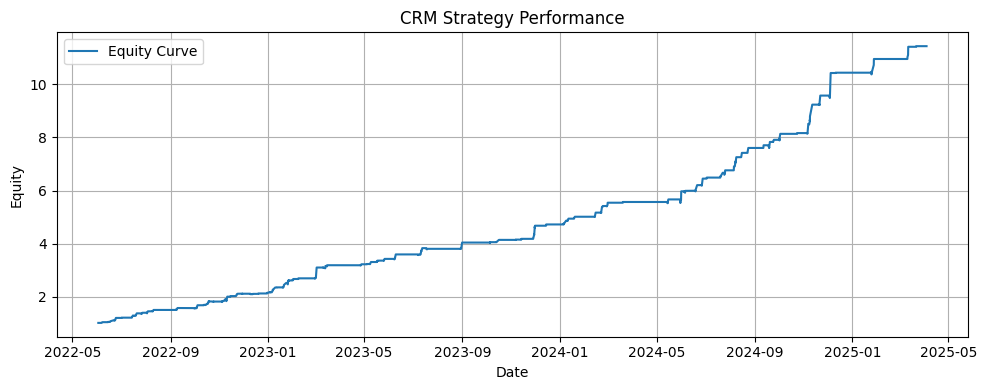

Processing NKE
Attempt 1: Downloading NKE stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for NKE
Performance Metrics for NKE:
   Sharpe Ratio: 1.2842
   Win/Loss Ratio: 1.9216
   Max Drawdown: -0.0421
   CAGR: nan
NKE meets filter criteria. Saving...


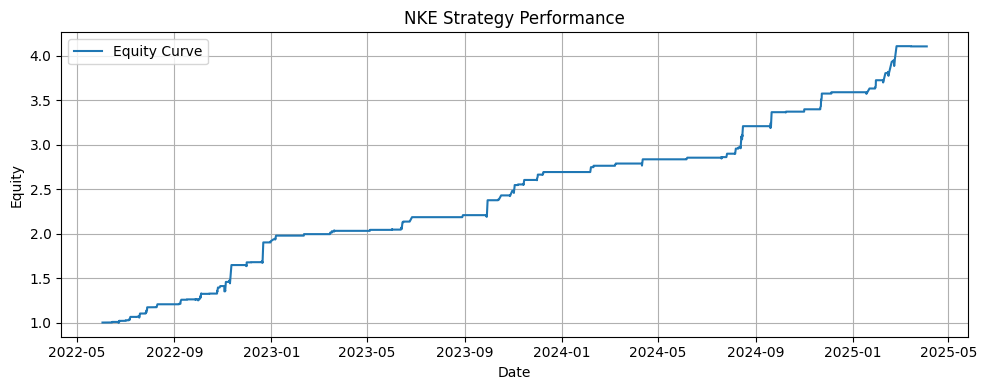

Processing INTC
Attempt 1: Downloading INTC stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for INTC
Performance Metrics for INTC:
   Sharpe Ratio: 2.1152
   Win/Loss Ratio: 1.9738
   Max Drawdown: -0.0608
   CAGR: nan
INTC meets filter criteria. Saving...


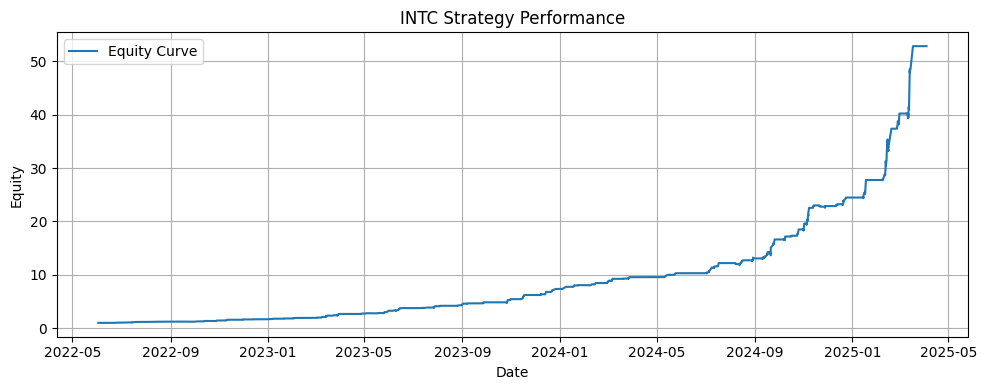

Processing QCOM
Attempt 1: Downloading QCOM stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for QCOM
Performance Metrics for QCOM:
   Sharpe Ratio: 2.2168
   Win/Loss Ratio: 2.4200
   Max Drawdown: -0.0220
   CAGR: nan
QCOM meets filter criteria. Saving...


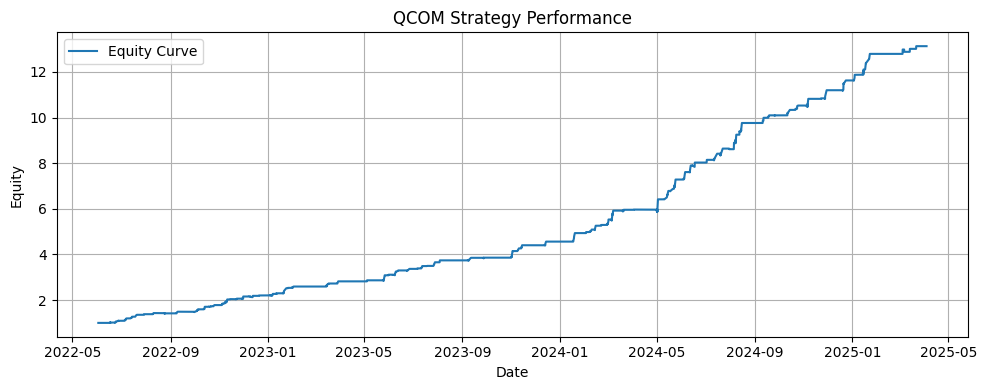

Processing NEE
Attempt 1: Downloading NEE stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for NEE
Performance Metrics for NEE:
   Sharpe Ratio: 1.6190
   Win/Loss Ratio: 2.3118
   Max Drawdown: -0.0214
   CAGR: nan
NEE meets filter criteria. Saving...


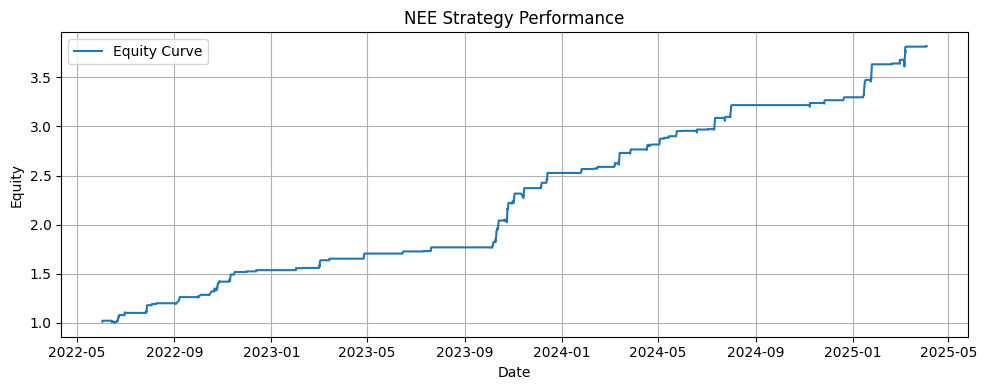

Processing AMD
Attempt 1: Downloading AMD stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for AMD
Performance Metrics for AMD:
   Sharpe Ratio: 2.5593
   Win/Loss Ratio: 2.1133
   Max Drawdown: -0.0622
   CAGR: nan
AMD meets filter criteria. Saving...


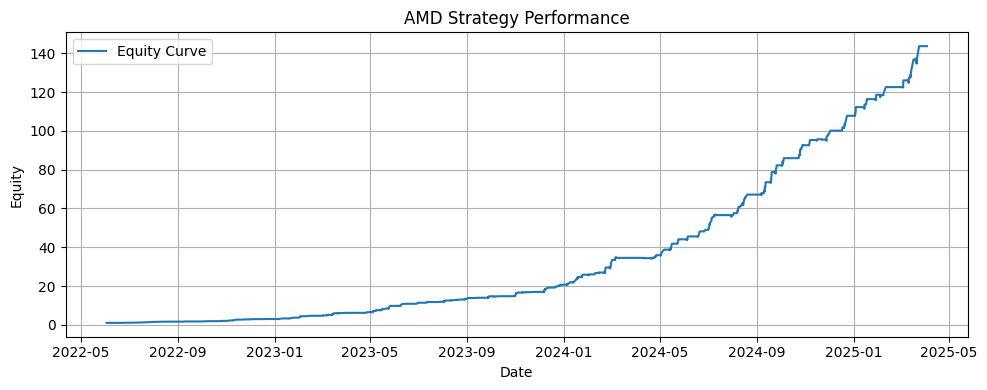

Processing TXN
Attempt 1: Downloading TXN stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for TXN
Performance Metrics for TXN:
   Sharpe Ratio: 1.6939
   Win/Loss Ratio: 1.8103
   Max Drawdown: -0.0174
   CAGR: nan
TXN meets filter criteria. Saving...


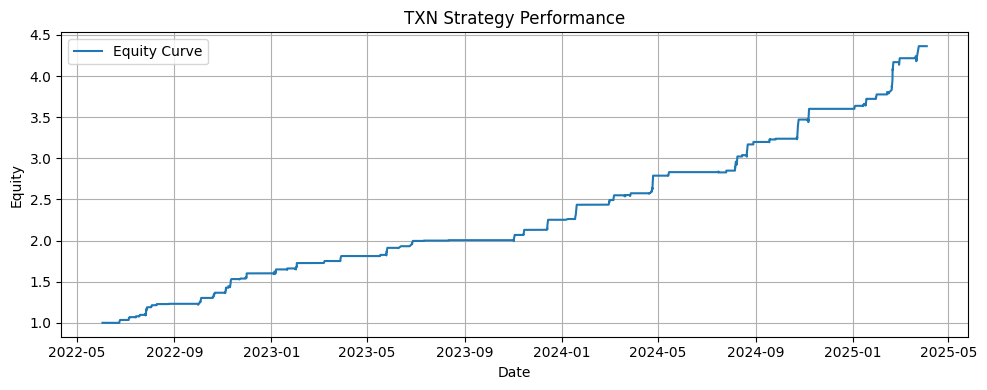

Exported 10 tickers meeting criteria.

🚀 Running chunk 5 with symbols: ['AMGN', 'UPS', 'LIN', 'PM', 'UNP', 'BMY', 'LOW', 'RTX', 'CVX', 'IBM']
Processing AMGN
Attempt 1: Downloading AMGN stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for AMGN
Performance Metrics for AMGN:
   Sharpe Ratio: 1.1654
   Win/Loss Ratio: 2.7170
   Max Drawdown: -0.0119
   CAGR: nan
AMGN meets filter criteria. Saving...


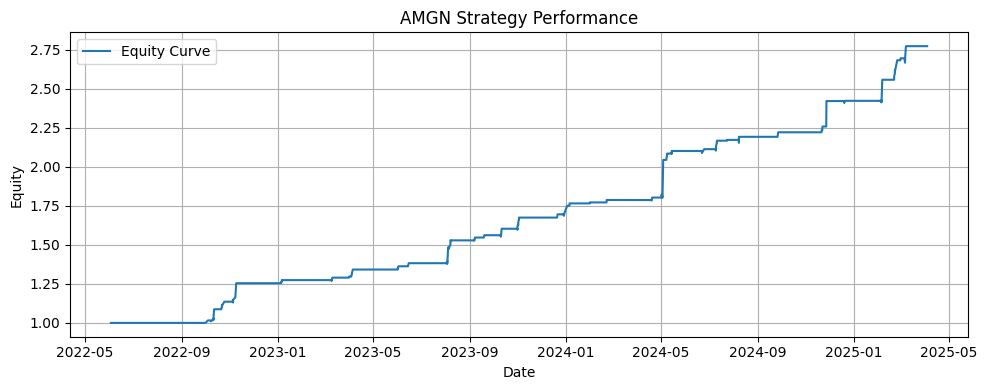

Processing UPS
Attempt 1: Downloading UPS stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for UPS
Performance Metrics for UPS:
   Sharpe Ratio: 1.3868
   Win/Loss Ratio: 2.1875
   Max Drawdown: -0.0226
   CAGR: nan
UPS meets filter criteria. Saving...


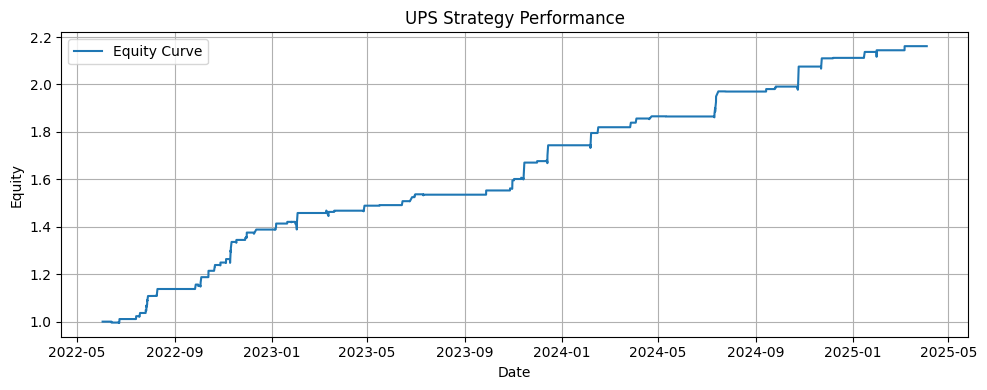

Processing LIN
Attempt 1: Downloading LIN stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for LIN
Performance Metrics for LIN:
   Sharpe Ratio: 1.0327
   Win/Loss Ratio: 2.5135
   Max Drawdown: -0.0244
   CAGR: nan
LIN meets filter criteria. Saving...


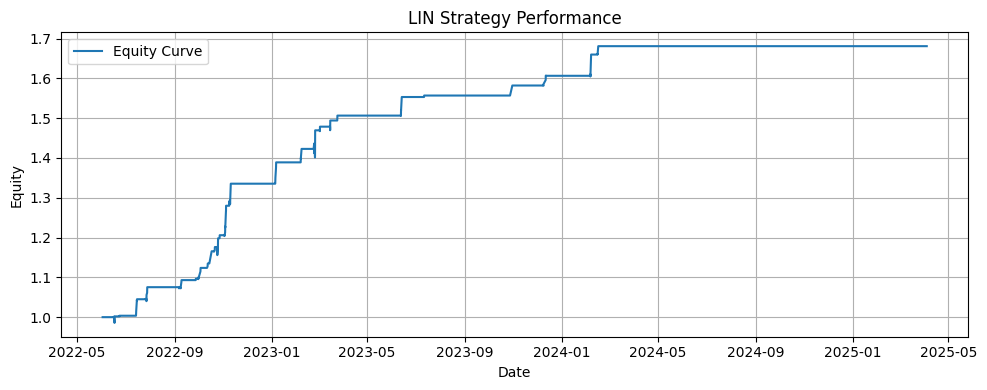

Processing PM
Attempt 1: Downloading PM stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for PM
Performance Metrics for PM:
   Sharpe Ratio: 0.8132
   Win/Loss Ratio: 2.3143
   Max Drawdown: -0.0115
   CAGR: nan
PM meets filter criteria. Saving...


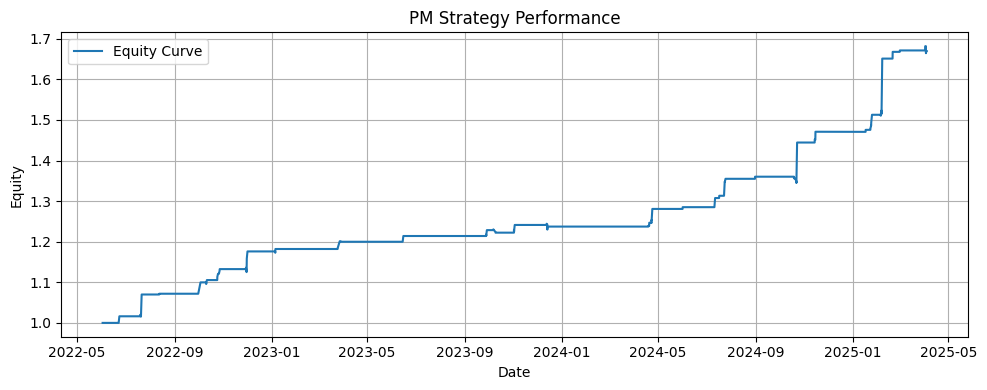

Processing UNP
Attempt 1: Downloading UNP stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for UNP
Performance Metrics for UNP:
   Sharpe Ratio: 1.0865
   Win/Loss Ratio: 2.2241
   Max Drawdown: -0.0133
   CAGR: nan
UNP meets filter criteria. Saving...


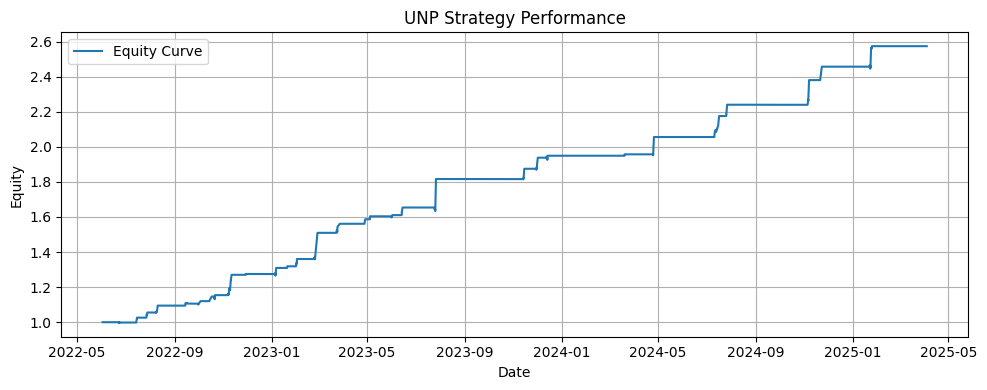

Processing BMY
Attempt 1: Downloading BMY stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for BMY
Performance Metrics for BMY:
   Sharpe Ratio: 0.9958
   Win/Loss Ratio: 2.0678
   Max Drawdown: -0.0174
   CAGR: nan
BMY meets filter criteria. Saving...


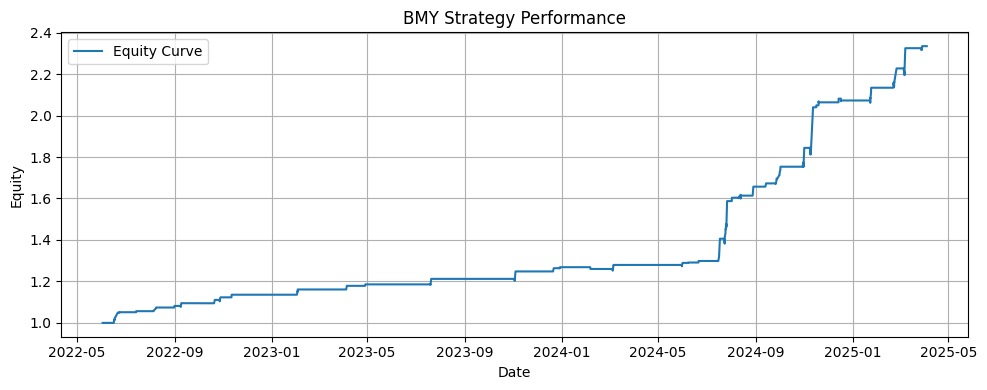

Processing LOW
Attempt 1: Downloading LOW stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for LOW
Performance Metrics for LOW:
   Sharpe Ratio: 1.5479
   Win/Loss Ratio: 1.9902
   Max Drawdown: -0.0190
   CAGR: nan
LOW meets filter criteria. Saving...


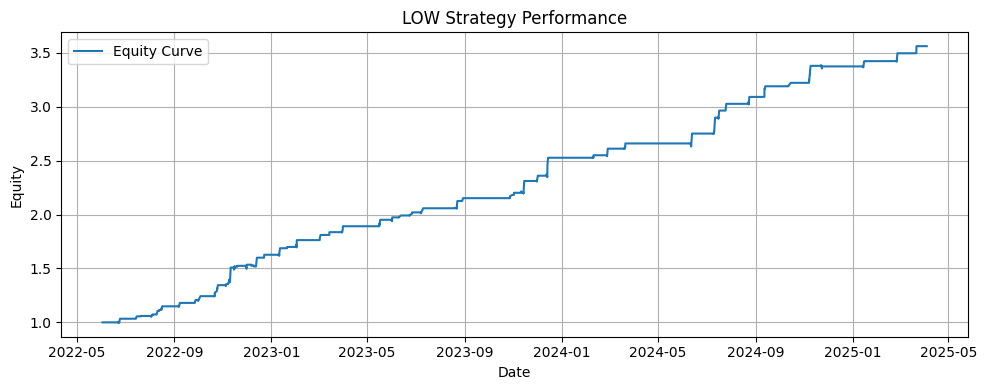

Processing RTX
Attempt 1: Downloading RTX stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for RTX
Performance Metrics for RTX:
   Sharpe Ratio: 1.0771
   Win/Loss Ratio: 1.8644
   Max Drawdown: -0.0191
   CAGR: nan
RTX meets filter criteria. Saving...


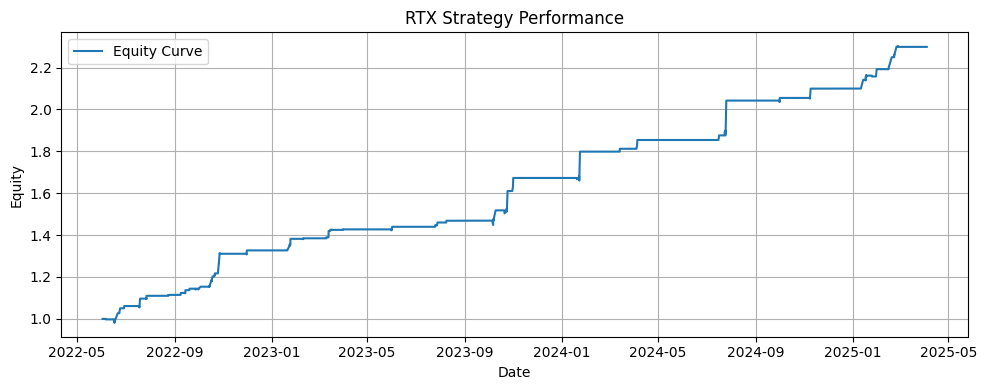

Processing CVX
Attempt 1: Downloading CVX stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for CVX
Performance Metrics for CVX:
   Sharpe Ratio: 1.3477
   Win/Loss Ratio: 2.6140
   Max Drawdown: -0.0252
   CAGR: nan
CVX meets filter criteria. Saving...


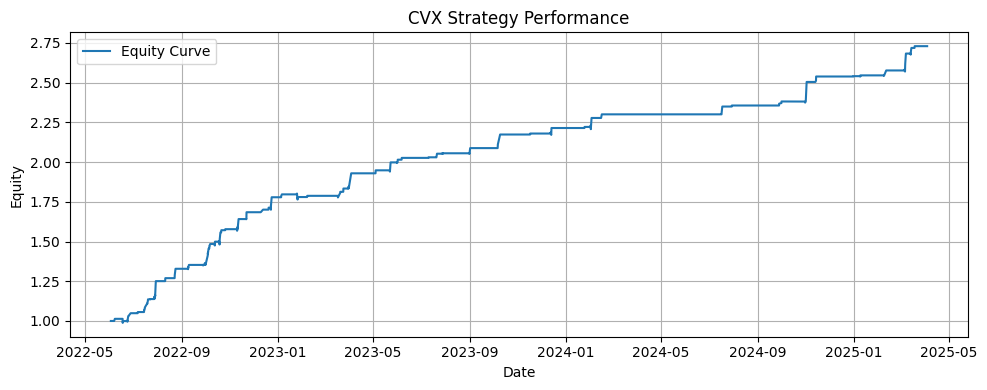

Processing IBM
Attempt 1: Downloading IBM stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for IBM
Performance Metrics for IBM:
   Sharpe Ratio: 0.8865
   Win/Loss Ratio: 2.5814
   Max Drawdown: -0.0173
   CAGR: nan
IBM meets filter criteria. Saving...


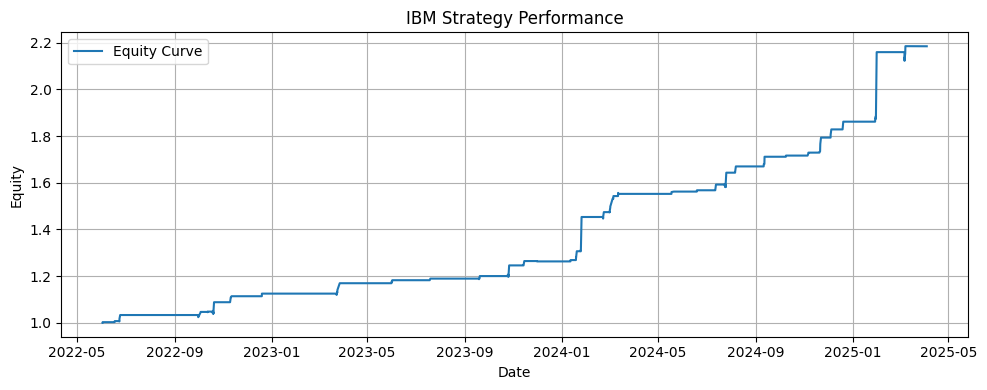

Exported 10 tickers meeting criteria.

🚀 Running chunk 6 with symbols: ['GE', 'SBUX', 'ORCL']
Processing GE
Attempt 1: Downloading GE stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for GE
Performance Metrics for GE:
   Sharpe Ratio: 1.7557
   Win/Loss Ratio: 2.0526
   Max Drawdown: -0.0372
   CAGR: nan
GE meets filter criteria. Saving...


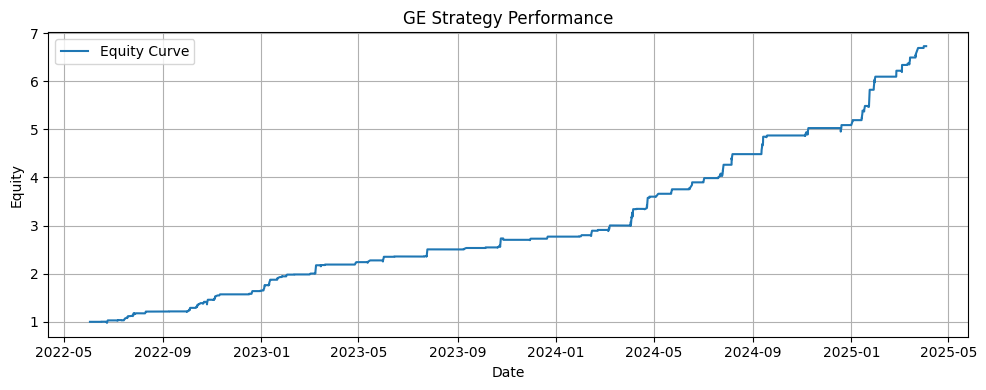

Processing SBUX
Attempt 1: Downloading SBUX stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for SBUX
Performance Metrics for SBUX:
   Sharpe Ratio: 1.0519
   Win/Loss Ratio: 2.3544
   Max Drawdown: -0.0443
   CAGR: nan
SBUX meets filter criteria. Saving...


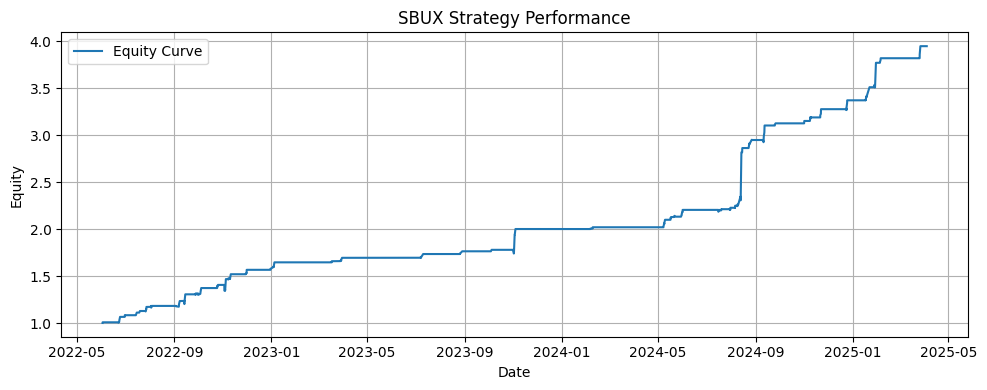

Processing ORCL
Attempt 1: Downloading ORCL stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for ORCL
Performance Metrics for ORCL:
   Sharpe Ratio: 1.4742
   Win/Loss Ratio: 1.8450
   Max Drawdown: -0.0471
   CAGR: nan
ORCL meets filter criteria. Saving...


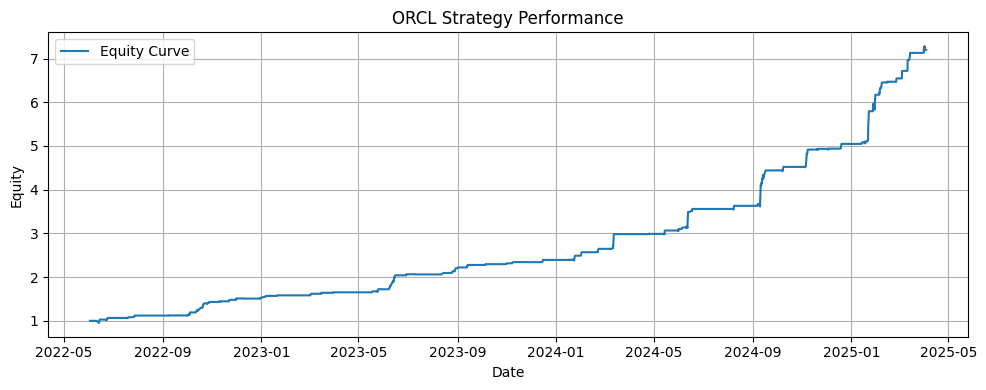

Exported 3 tickers meeting criteria.
Total tickers meeting criteria: 3
Tickers: ['GE', 'SBUX', 'ORCL']
All results compressed into 'universal_strategy_outputs.zip'


In [54]:
# Save the full list separately
full_symbol_list = CONFIG['symbols']
chunk_size = 10  # You can increase this if needed

# Track all winners across batches
global_results = {}
global_metrics = {}
global_filtered = []

for i in range(0, len(full_symbol_list), chunk_size):
    CONFIG['symbols'] = full_symbol_list[i:i + chunk_size]
    print(f"\n🚀 Running chunk {i // chunk_size + 1} with symbols: {CONFIG['symbols']}")

    # Run your pipeline
    all_results, all_metrics, filtered_tickers = run_universal_framework(CONFIG)

    # Store in global containers
    global_results.update(all_results)
    global_metrics.update(all_metrics)
    global_filtered.extend(filtered_tickers)


print(f"Total tickers meeting criteria: {len(filtered_tickers)}")
print("Tickers:", filtered_tickers)

with zipfile.ZipFile("/content/universal_strategy_outputs.zip", "w") as zipf:
    for ticker in filtered_tickers:
        zipf.write(f"/content/{ticker}_universal_features.csv", arcname=f"{ticker}_universal_features.csv")
        zipf.write(f"/content/{ticker}_metrics_summary.csv", arcname=f"{ticker}_metrics_summary.csv")

print("All results compressed into 'universal_strategy_outputs.zip'")